In [1]:
#import neccessary libraries
import numpy as np
import evaluation as ev
import csv
import pandas as pd

In [2]:
#modified test_single_photon function (taken from test_stats.py) that returns number of clusters
#this function calls our model and tests it using the root file defined in datasets.py in the single_photon_dataset function
#modifications w.r.t evaluations.py:
#-added n_events & noise variables to define number of events & singal threshold each time we call our function
#-added n_clusters variable which gets the length of our clustering array, thus our number of clusters
#-deleted plotly data functions to save compilation time
def n_clusters(n_events, noise):
    tbeta = .2
    td = .5
    nmax = n_events
    yielder = ev.TestYielderSinglePhoton()
    yielder.model.signal_threshold = noise
    n_clusters = np.zeros(shape=(nmax))
    for i, (event, prediction, clustering) in enumerate(yielder.iter_clustering(tbeta, td, nmax=nmax)):
        n_clusters[i] = len(np.unique(clustering))
    return n_clusters

In [3]:
#set run parameters
n_events = 1000
noise_range = range(1,20)
noise_step = 0.05
n_clusters_mean = np.zeros(shape=(len(noise_range)))

#create .csv file to write our results on
with open('cluster-noise-distribution_Gamma-E25-n1000-part9.csv', 'w') as f:
    fieldnames = ['noise', 'n_events', 'n_clusters_mean']
    writer = csv.DictWriter(f,fieldnames=fieldnames)
    writer.writeheader()
    #call our function and loop over incremental noise values (step set by noise_step)
    for noise_i in noise_range:
        noise = np.round(noise_i*noise_step,2)
        n_clusters_mean[noise_i-1] = np.round(np.mean(n_clusters(n_events, noise)), 2)
        writer.writerow({'noise': noise, 'n_events': n_events, 'n_clusters_mean': n_clusters_mean[noise_i-1]})
        #print(noise_i, noise, n_events, n_clusters, n_clusters_mean[noise_i-1])

100%|███████████████████████████████████████| 1000/1000 [05:03<00:00,  3.30it/s]


In [4]:
# read our results as a pandas dataframe
df = pd.read_csv('cluster-noise-distribution_Gamma-E25-n1000-part9.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   noise            19 non-null     float64
 1   n_events         19 non-null     int64  
 2   n_clusters_mean  19 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 584.0 bytes


In [5]:
#print out dataframe
df

,noise,n_events,n_clusters_mean
0,0.05,1000,7.11
1,0.10,1000,3.46
2,0.15,1000,2.74
3,0.20,1000,2.41
4,0.25,1000,2.36
5,0.30,1000,2.44
6,0.35,1000,2.62
7,0.40,1000,2.93
8,0.45,1000,3.40
9,0.50,1000,3.91


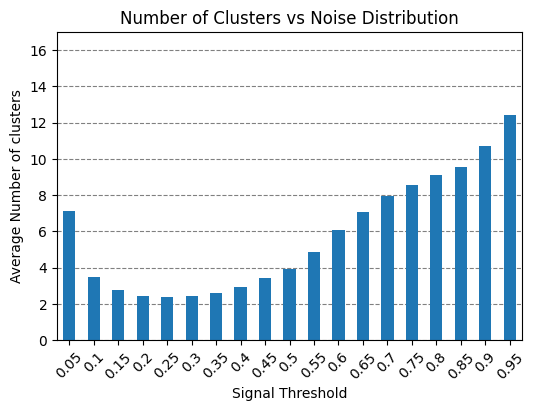

In [6]:
#plots results & save as .png
ymin = 0
ymax = np.int(df['n_clusters_mean'].max()) + 5

ax = df.plot('noise', 'n_clusters_mean', 
        kind='bar', 
        title = 'Number of Clusters vs Noise Distribution',
        ylabel = 'Average Number of clusters', 
        xlabel='Signal Threshold',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.get_figure().savefig('cluster_noise_distribution-Gamma-E25-n1000-part9.png', bbox_inches = 'tight')

In [7]:
#modifiedtest_single_photon function (taken from test_stats.py) that returns cluster per hit & energy per hit
#this function calls our model and tests it using the root file defined in datasets.py in the single_photon_dataset function
def clusters_info(n_events, noise):
    tbeta = .2
    td = .5
    nmax = n_events
    yielder = ev.TestYielderSinglePhoton()
    yielder.model.signal_threshold = noise
    event_n = []
    event_cluster = []
    cluster_energy = []
    cluster_nhits = []
    for i, (event, prediction, clustering) in enumerate(yielder.iter_clustering(tbeta, td, nmax=nmax)):
        #see https://stackoverflow.com/questions/67108215/how-to-get-sum-of-values-in-a-numpy-array-based-on-another-array-with-repetitive
        np.set_printoptions(suppress=True) #suppress scientific notation
        _, idx, _ = np.unique(clustering, return_counts=True, return_inverse=True)
        energy_values = np.round(np.bincount(idx, event.energy),3)
        event_cluster_unique, n_hits = np.unique(clustering, return_counts=True, return_index=False)
        event_i = np.full(len(event_cluster_unique), i, dtype=int)
        event_n = np.append(event_n, event_i)
        event_cluster = np.append(event_cluster, event_cluster_unique)
        cluster_nhits = np.append(cluster_nhits, n_hits)
        cluster_energy = np.append(cluster_energy, energy_values)
    return event_n, event_cluster, cluster_nhits, cluster_energy

In [8]:
#get cluster info for n_events with the noise value where avg number of clusters is minimized
n_events = 1000
noise_min = df['noise'][df['n_clusters_mean'].idxmin()]
event_n, event_cluster, cluster_nhits, cluster_energy = clusters_info(n_events,noise_min)

100%|███████████████████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]


In [13]:
#create pandas dataframe with resuls from cluster info
ci = event_n, event_cluster, cluster_nhits, cluster_energy
df_ci = pd.DataFrame({'event_n': ci[0].astype(np.int64), 'event_clusters': ci[1].astype(np.int64), 'n_hits': ci[2].astype(np.int64), 'energy_value': ci[3]})
df_ci

,event_n,event_clusters,n_hits,energy_value
0,0,0,18185,144.778
1,0,9,6,0.046
2,0,18,1,0.017
3,0,75,276,23.510
4,1,0,17719,141.664
...,...,...,...,...
2357,997,26,276,25.103
2358,998,0,18270,144.978
2359,998,55,212,22.524
2360,999,0,17902,143.997


In [15]:
#calculate percentage of energy by cluster, per event
df_ci['energy_percentage'] = df_ci['energy_value'] / df_ci.groupby('event_n')['energy_value'].transform('sum')
df_ci

,event_n,event_clusters,n_hits,energy_value,energy_percentage
0,0,0,18185,144.778,0.859977
1,0,9,6,0.046,0.000273
2,0,18,1,0.017,0.000101
3,0,75,276,23.510,0.139649
4,1,0,17719,141.664,0.858804
...,...,...,...,...,...
2357,997,26,276,25.103,0.147701
2358,998,0,18270,144.978,0.865530
2359,998,55,212,22.524,0.134470
2360,999,0,17902,143.997,0.853903


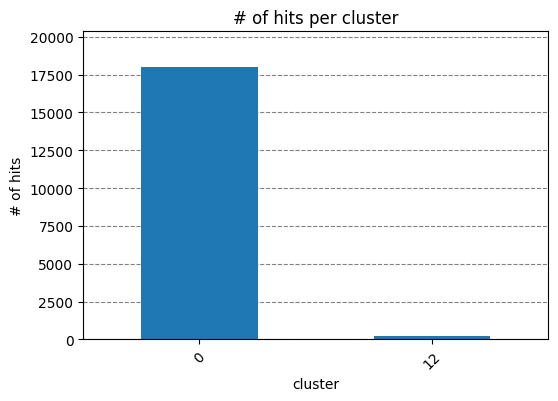

In [17]:
#plots number of htis & save as .png
ymin = 0
ymax = np.int(df_ci['n_hits'].max()) + np.int(df_ci['n_hits'].max())/10

#get random event to plot
random_n = np.random.randint(0, high=101, size=None, dtype=int)

ax = df_ci[df_ci['event_n']==random_n].plot('event_clusters', 'n_hits', 
        kind='bar', 
        title = '# of hits per cluster',
        ylabel = '# of hits', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.get_figure().savefig('cluster_info_nhits-Gamma-E25-n1000-part9.png', bbox_inches = 'tight')

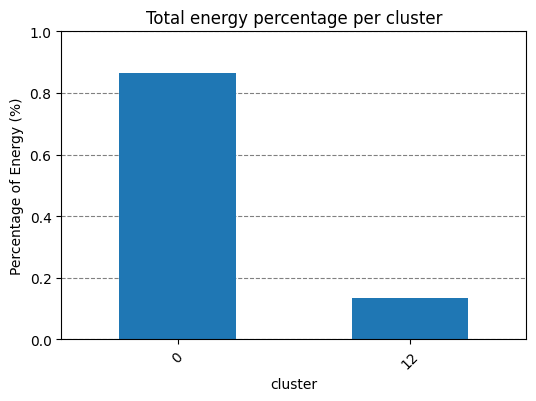

In [18]:
#plots energy percentage for same event & save as .png
ymin = 0
ymax = 1

ax = df_ci[df_ci['event_n']==random_n].plot('event_clusters', 'energy_percentage', 
        kind='bar', 
        title = 'Total energy percentage per cluster',
        ylabel = 'Percentage of Energy (%)', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.get_figure().savefig('cluster_info_energy-Gamma-E25-n1000-part9.png', bbox_inches = 'tight')

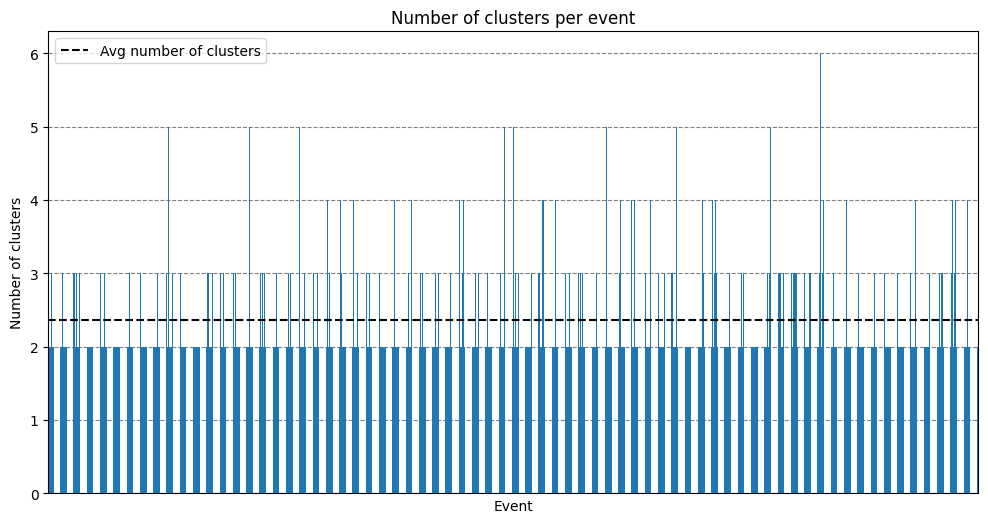

In [19]:
#plot distribution of number of clusters per event alongisde avg number of clusters
n_clusters_avg = df.loc[df['noise'] == noise_min, 'n_clusters_mean'].iloc[0]

ax = df_ci.groupby(['event_n'])['event_clusters'].count().plot(
        kind='bar', 
        title = 'Number of clusters per event',
        ylabel = 'Number of clusters', 
        xlabel=  'Event',
        rot = 90,
        legend = False,
        label='_nolegend_',
        xticks=[],
        figsize=(12, 6))

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.axhline(n_clusters_avg, color='k', linestyle='--', label='Avg number of clusters')

ax.legend()
#ax.get_figure().savefig('cluster_info_clusters_per_event-test.png', bbox_inches = 'tight')

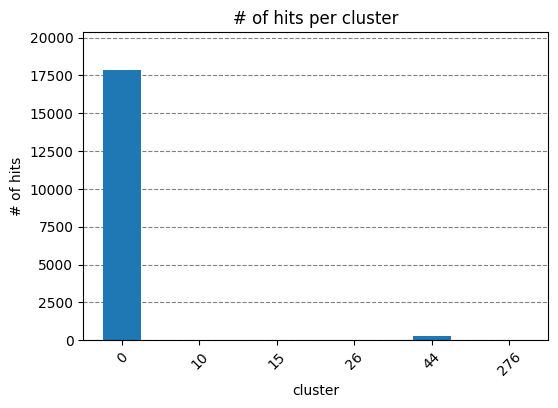

In [20]:
#plots number of hits event with highest number of clusters& save as .png
ymin = 0
ymax = np.int(df_ci['n_hits'].max()) + np.int(df_ci['n_hits'].max())/10

#get revent with highest number of clusters
event_nclusters_max = df_ci.groupby(['event_n'])['event_clusters'].count().idxmax()

ax = df_ci[df_ci['event_n']== event_nclusters_max].plot('event_clusters', 'n_hits', 
        kind='bar', 
        title = '# of hits per cluster',
        ylabel = '# of hits', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.get_figure().savefig('cluster_info_nhits-test.png', bbox_inches = 'tight')

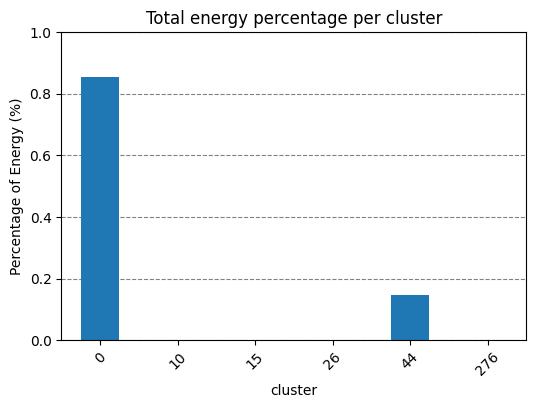

In [21]:
#plots energy values for event with highest number of clusters & save as .png
ymin = 0
ymax = 1

#get revent with highest number of clusters
event_nclusters_max = df_ci.groupby(['event_n'])['event_clusters'].count().idxmax()

ax = df_ci[df_ci['event_n']==event_nclusters_max].plot('event_clusters', 'energy_percentage', 
        kind='bar', 
        title = 'Total energy percentage per cluster',
        ylabel = 'Percentage of Energy (%)', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.get_figure().savefig('cluster_info_energy-test.png', bbox_inches = 'tight')

In [22]:
#add column that counts the number of clusters per event starting from zero
df_ci['cluster_count'] = df_ci.groupby(df_ci['event_n'].diff().ne(0).cumsum()).cumcount()

In [27]:
#create dataframe for each cluster along their nhits & energy percentage value, per event
cluster_nhits = np.zeros(shape=(n_events),dtype=int)
cluster_epercentage = np.zeros(shape=(n_events))
cluster_evalue = np.zeros(shape=(n_events))

cluster_n = 0

event_n = df_ci[df_ci['cluster_count']==cluster_n]['event_n']

cluster_nhits[event_n] = df_ci[df_ci['cluster_count']==cluster_n]['n_hits']
cluster_epercentage[event_n] = df_ci[df_ci['cluster_count']==cluster_n]['energy_percentage']
cluster_evalue[event_n] = df_ci[df_ci['cluster_count']==cluster_n]['energy_value']

df_ci_n = pd.DataFrame({'cluster_nhits': cluster_nhits, 'cluster_evalue': cluster_evalue, 'cluster_epercentage': cluster_epercentage})
df_ci_n.index.name = 'event_n'
df_ci_n = df_ci_n.reset_index()

#get avg number of hits
nhits_avg = df_ci_n['cluster_nhits'].mean()

#get avg energy percentage
epercentage_avg = df_ci_n['cluster_epercentage'].mean()

df_ci_n

,event_n,cluster_nhits,cluster_evalue,cluster_epercentage
0,0,18185,144.778,0.859977
1,1,17719,141.664,0.858804
2,2,18036,144.289,0.860646
3,3,17810,143.241,0.865918
4,4,18133,145.341,0.851531
...,...,...,...,...
995,995,18139,144.538,0.860325
996,996,17994,144.266,0.854727
997,997,18018,144.855,0.852299
998,998,18270,144.978,0.865530


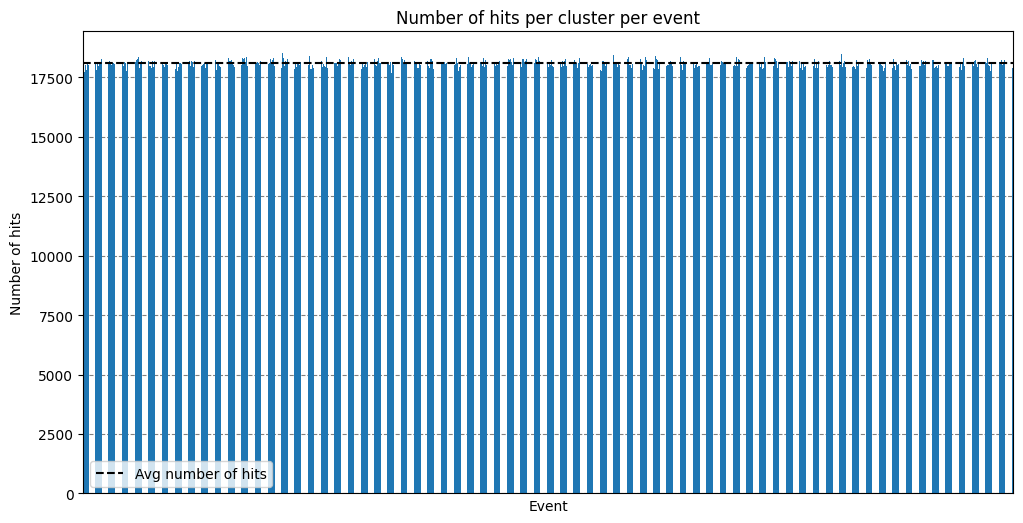

In [28]:
#plot nhits per # of cluster per event (i.e nhits for the 1st cluster of each event)

ax = df_ci_n.plot('event_n','cluster_nhits',
        kind='bar', 
        title = 'Number of hits per cluster per event',
        ylabel = 'Number of hits', 
        xlabel=  'Event',
        rot = 90,
        legend = False,
        label='_nolabel_',
        xticks=[],
        figsize=(12, 6))

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.axhline(nhits_avg, color='k', linestyle='--', label='Avg number of hits')

ax.legend(loc='lower left')
#ax.get_figure().savefig('cluster_info_clusters_per_event-test.png', bbox_inches = 'tight')

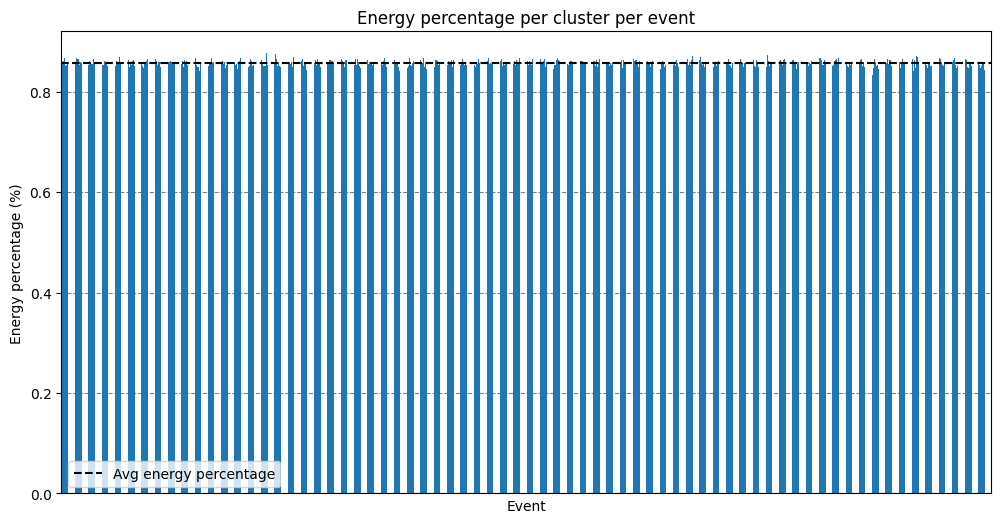

In [29]:
#plot nhits per # of cluster per event (i.e nhits for the 1st cluster of each event, nhits for the 2nd, and so on)

ax = df_ci_n.plot('event_n','cluster_epercentage',
        kind='bar', 
        title = 'Energy percentage per cluster per event',
        ylabel = 'Energy percentage (%)', 
        xlabel=  'Event',
        rot = 90,
        legend = False,
        label='_nolabel_',
        xticks=[],
        figsize=(12, 6))

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.axhline(epercentage_avg, color='k', linestyle='--', label='Avg energy percentage')

ax.legend(loc='lower left')
#ax.get_figure().savefig('cluster_info_clusters_per_event-test.png', bbox_inches = 'tight')